In [3]:
from lambeq import BobcatParser, SpacyTokeniser
import torch, numpy, pandas as pd, re

In [4]:
def create_list(num,maxi):
    lst = [0] * maxi
    lst[num] = 1
    return lst

Let us read the files with the sentences, clean them and put the sentences into a new files.

In [5]:
def clean_text(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    text =  ' '.join(text.split())
    #print(text)
    return text

In [6]:
def process_csv_lines(input_file_path, output_file_path):
    """
    Reads a CSV file, processes each line to remove all commas except the last one,
    and writes the processed lines to a new file.
    """
    with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            if ',' in line:
                parts = line.rsplit(',', 1)  # Split from the right at the last comma
                new_line = parts[0].replace(',', '') # Remove all commas from the first part
            else:
                new_line = line  # If no comma is present, leave the line unchanged
            
            output_file.write(clean_text(new_line)+ ',' + parts[1])



In [7]:
# Process Train dataset 
input_file = "dataset_dim2/train_dataset.csv"
output_file = "dataset_dim2/train_clean_data.csv"
process_csv_lines(input_file,output_file)

In [8]:
# Process Test dataset
input_file = "dataset_dim2/test_dataset.csv"
output_file = "dataset_dim2/test_clean_data.csv"
process_csv_lines(input_file,output_file)

In [11]:
column_names = ["text", "label"]
train_dataset = pd.read_csv("dataset_dim2/train_clean_data.csv", names=column_names).sample(frac = 1, )
test_dataset = pd.read_csv("dataset_dim2/test_clean_data.csv", names=column_names).sample(frac = 1)

In [12]:
train_dataset[:10]

,text,label
21,the documentary was enlightening shedding ligh...,0
135,her strategies are outdated and ineffective,1
40,the project was completed ahead of schedule an...,0
190,the storyline is filled with inconsistencies,1
62,the restaurants ambiance adds to the dining ex...,0
94,the programs success is testament to their har...,0
69,his contributions to the project were pivotal,0
59,her dedication to her students success is rema...,0
170,the theme was poorly developed and lacked cohe...,1
189,his input on the project was negligible,1


In [13]:
test_dataset[:10]

,text,label
38,his management style is authoritarian and demo...,1
57,the book is filled with clichés and predictabl...,1
13,the course content was comprehensive and well ...,0
3,her talk on innovation was stimulating and tho...,0
11,the apps latest update has significantly impro...,0
55,the projects scope was not clearly defined lea...,1
19,his photography captures the essence of urban ...,0
35,the service at the cafe was slow and disorganized,1
51,the instructions were complicated and hard to ...,1
45,the buildings maintenance has been neglected,1


In [14]:
from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser()

train_data = [tokeniser.tokenise_sentence(sent) for sent in train_dataset.iloc[:, 0].to_list()]
#train_labels = [create_list(ele,4) for ele in train_dataset.iloc[:, 1].to_list()]
test_data = [tokeniser.tokenise_sentence(sent) for sent in test_dataset.iloc[:, 0].to_list()]
#test_labels = [create_list(ele,4) for ele in test_dataset.iloc[:, 1].to_list()]

train_labels = [[1-x, x] for x in train_dataset.iloc[:, 1].to_list()]
test_labels = [[1-x, x] for x in test_dataset.iloc[:, 1].to_list()]

## Text 2 Diagram

In [120]:
parser = BobcatParser(root_cats=('NP', 'N'))
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True, tokenised=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True, tokenised=True)

Tagging sentences:   0%|          | 0/50 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/199 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/199 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/15 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/60 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/60 [00:00<?, ?it/s]

In [121]:
print("Number of Train diagrams", len(train_diagrams), "and labels", len(train_labels), "match? ->", len(train_diagrams) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams), "and labels", len(test_labels), "match? ->", len(test_diagrams) == len(test_labels))

Number of Train diagrams 199 and labels 199 match? -> True
Number of Test diagrams 60 and labels 60 match? -> True


In [122]:
train_diagrams_filter = []

for index,diagram in enumerate(train_diagrams):
    if diagram is not None:
        train_diagrams_filter.append(diagram.normal_form())
    else:
        train_labels[index] = None
        
test_diagrams_filter = []

for index,diagram in enumerate(test_diagrams):
    if diagram is not None:
        test_diagrams_filter.append(diagram.normal_form())
    else:
        test_labels[index] = None

In [123]:
def remove_none(ll):
    return [x for x in ll if x is not None]

train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [124]:
print("Number of Train diagrams", len(train_diagrams_filter), "and labels", len(train_labels), "match? ->", len(train_diagrams_filter) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams_filter), "and labels", len(test_labels), "match? ->", len(test_diagrams_filter) == len(test_labels))

Number of Train diagrams 198 and labels 198 match? -> True
Number of Test diagrams 60 and labels 60 match? -> True


View the diagram of a sentence to make sure taht everything is working fine

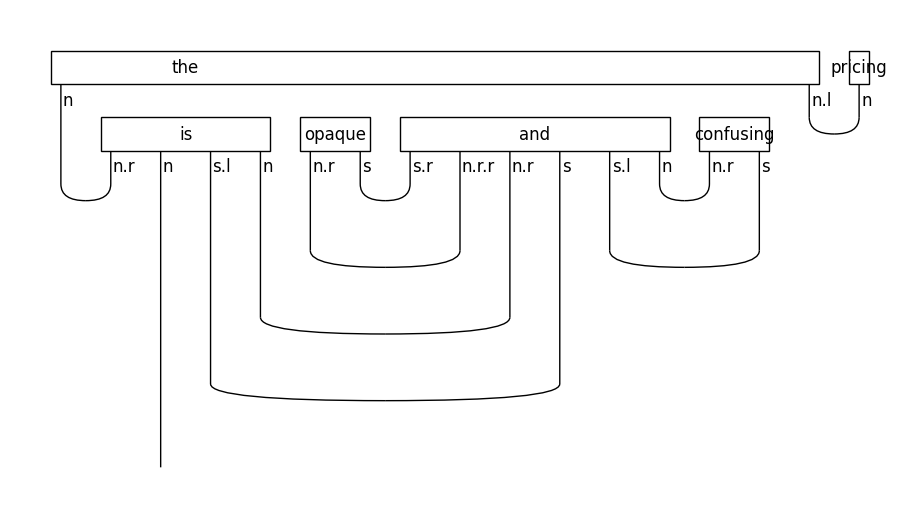

In [125]:
train_diagrams_filter[11].normal_form().draw(figsize=(9, 5), fontsize=12)

## Diagram 2 Circuit

In [132]:
from lambeq import AtomicType, IQPAnsatz
from lambeq.backend.tensor import Dim

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE
prep = AtomicType.PREPOSITIONAL_PHRASE

# Create an ansatz
ansatz = IQPAnsatz({prep:1, noun: 1, sentence_type: 1},n_layers=1,n_single_qubit_params=5)

train_circuits = []
test_circuits =  []

for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Train diagram",index, "-> sentence is:", train_dataset.iloc[index,0])
        train_labels[index] = None
        #print(e)

for index,diag in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Test diagram",index, "-> sentence is:", test_dataset.iloc[index,0])
        test_labels[index] = None
        #print(e)



#train_circuits[0].draw(figsize=(9, 10))

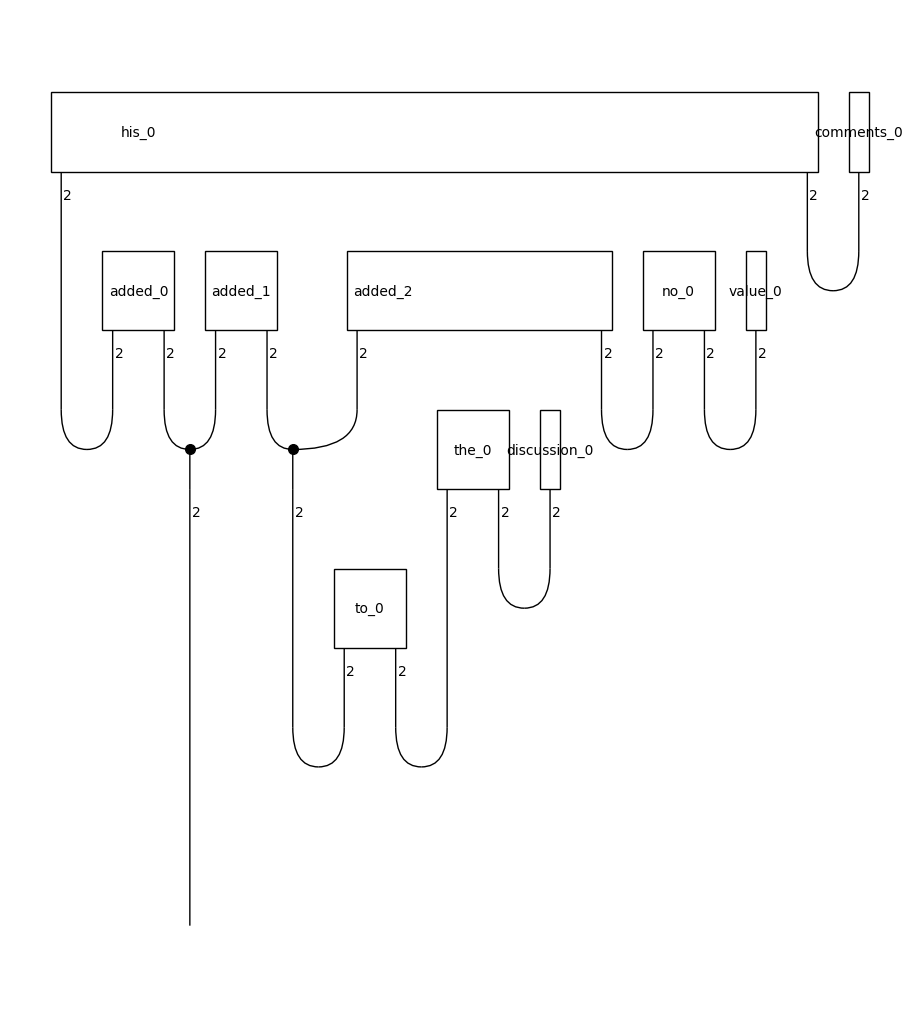

In [135]:
train_circuits[0].draw(figsize=(9, 10))

In [136]:
train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [137]:
print("Number of Train circuits", len(train_circuits), "and labels", len(train_labels), "match? ->", len(train_circuits) == len(train_labels))
print("Number of Test circuits", len(test_circuits), "and labels", len(test_labels), "match? ->", len(test_circuits) == len(test_labels))

Number of Train circuits 198 and labels 0 match? -> False
Number of Test circuits 60 and labels 0 match? -> False


In [86]:
"""
train_diagrams_filter[7].draw(figsize=(9, 1.5))
train_diagrams_filter[43].draw()
train_diagrams_filter[51].draw()
"""

'\ntrain_diagrams_filter[7].draw(figsize=(9, 1.5))\ntrain_diagrams_filter[43].draw()\ntrain_diagrams_filter[51].draw()\n'

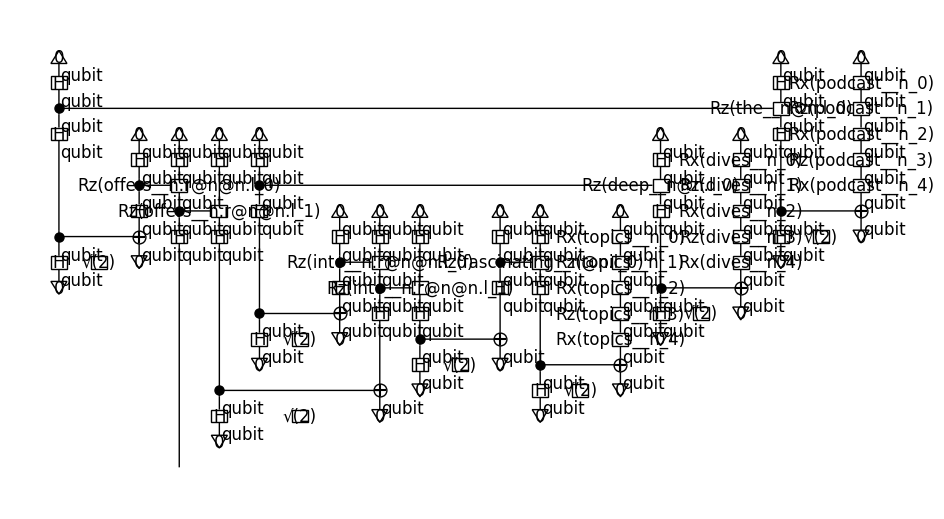

In [87]:
train_circuits[2].draw(figsize=(9, 5), fontsize=12)

In [55]:
# TESTING

'''
# Parse a sentence into a diagram
parser = BobcatParser(verbose='text')
sentence = "This is a simple example."
ccg_diagram = parser.sentence2diagram(sentence)

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE

# Create an ansatz (IQPAnsatz in this example)
ansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=3)

# Convert the CCG diagram into a quantum circuit
circuit = ansatz(train_diagrams_filter[0])

# Now `circuit` is a pytket circuit ready for simulation or running on a quantum computer
circuit.draw()
'''

'\n# Parse a sentence into a diagram\nparser = BobcatParser(verbose=\'text\')\nsentence = "This is a simple example."\nccg_diagram = parser.sentence2diagram(sentence)\n\n# Define types for the ansatz\nnoun = AtomicType.NOUN\nsentence_type = AtomicType.SENTENCE\n\n# Create an ansatz (IQPAnsatz in this example)\nansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=3)\n\n# Convert the CCG diagram into a quantum circuit\ncircuit = ansatz(train_diagrams_filter[0])\n\n# Now `circuit` is a pytket circuit ready for simulation or running on a quantum computer\ncircuit.draw()\n'

In [56]:
# Testing with SpiderAnsatz

"""
from lambeq.backend.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

remove_cups = RemoveCupsRewriter()

train_circuits = []
test_circuits =  []


for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Train diagram",index)
        train_labels[index] = None
        print(e)

for index,d in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Test diagram",index)
        test_labels[index] = None
        print(e)
"""

'\nfrom lambeq.backend.tensor import Dim\n\nfrom lambeq import AtomicType, SpiderAnsatz\n\nansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),\n                       AtomicType.SENTENCE: Dim(2)})\n\nremove_cups = RemoveCupsRewriter()\n\ntrain_circuits = []\ntest_circuits =  []\n\n\nfor index, diag in enumerate(train_diagrams_filter):\n    try:\n        train_circuits.append(ansatz(remove_cups(diag)))\n    except Exception as e:\n        print("Problem with Train diagram",index)\n        train_labels[index] = None\n        print(e)\n\nfor index,d in enumerate(test_diagrams_filter):\n    try:\n        test_circuits.append(ansatz(remove_cups(diag)))\n    except Exception as e:\n        print("Problem with Test diagram",index)\n        test_labels[index] = None\n        print(e)\n'

In [21]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(30, 6), asymmetry=0.3, fontsize=12)

NameError: name 'remove_cups' is not defined

## Training

In [88]:
import numpy as np

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y)/2

eval_metrics = {"acc": acc}

In [95]:
BATCH_SIZE = 30
EPOCHS = 30


In [96]:
from lambeq import NumpyModel

all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [97]:
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import BinaryCrossEntropyLoss

bce = BinaryCrossEntropyLoss(use_jax=True)

trainer = QuantumTrainer(
        model=model,
        loss_function=bce,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a':0.05, 'c':0.06, 'A':0.001*EPOCHS},
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text')

In [98]:
from lambeq import Dataset

new_train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)

new_test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [99]:
trainer.fit(new_train_dataset, new_test_dataset, eval_interval=1, log_interval=5)

Epoch 5:   train/loss: 1.2648   valid/loss: 1.0749   train/acc: 0.5253   valid/acc: 0.5333
Epoch 10:  train/loss: 0.7546   valid/loss: 0.9729   train/acc: 0.5429   valid/acc: 0.5833
Epoch 15:  train/loss: 0.7069   valid/loss: 0.8619   train/acc: 0.5707   valid/acc: 0.6333
Epoch 20:  train/loss: 0.8103   valid/loss: 0.9265   train/acc: 0.6035   valid/acc: 0.6000
Epoch 25:  train/loss: 0.6667   valid/loss: 0.9411   train/acc: 0.6313   valid/acc: 0.5667
Epoch 30:  train/loss: 0.8106   valid/loss: 0.8589   train/acc: 0.6667   valid/acc: 0.6167

Training completed!


In [107]:
print(acc(list(model(test_circuits)), test_labels))

0.6166666666666667


Test accuracy: 0.0


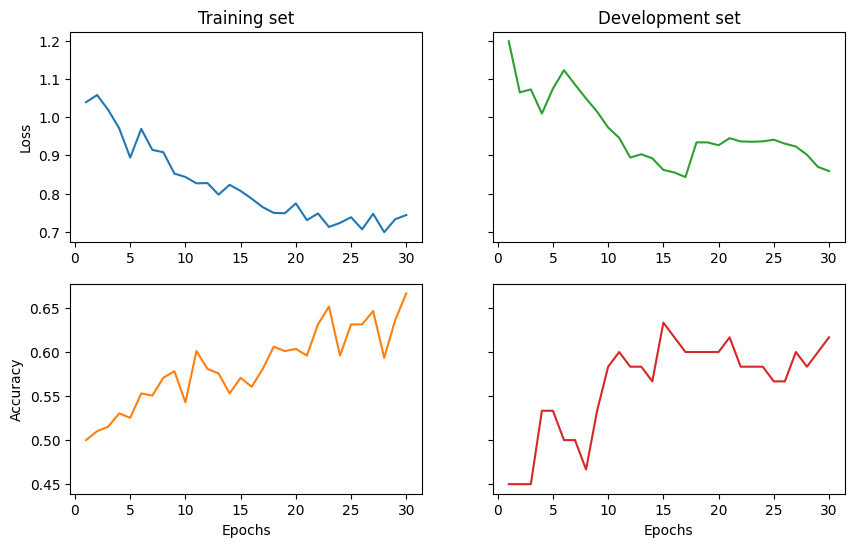

In [108]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())